In [1]:
import sys, os
from importlib import reload
import json, csv

import math , pywt , numpy as np, pandas as pd
import scipy.stats as stats, scipy.signal as signal

from IPython.display import display, HTML
from matplotlib import pyplot as plt


from utils import *
import constants
reload(constants)
from constants import *

--> Importing bpmn_utils module file.

--> Importing grouped_mean module file.

--> Importing lhipa_utils module file.



## Config & functions

In [2]:
#---------------------------------------------------
#
# Config *** TO UPDATE ***
#
#---------------------------------------------------

IMG_DIR = DATA_DIR + 'img'
if not os.path.exists(IMG_DIR): os.mkdir(IMG_DIR)

EYE_IMOTIONSFEATURES_AND_AOIS_FILE = DATA_DIR + r'\eventsDataWithAois.csv' 
PERCEIVED_DIFFICULTY_DATA = DATA_DIR + r'\perceivedDifficulty.csv'
EYEMIND_FULL_DATA = DATA_DIR + r'\allDataEyeMind.csv'
PUPIL_FILTERED_FILE = DATA_DIR + r'\PupilData_filtered.csv'
ANSWERS_DATA = DATA_DIR + r'\answers.csv'

QUESTION_FILE_PARSED = ORIG_DIR + r'\QuestionSetParsed.csv'
QUESTION_DETAILS = ORIG_DIR + r'\QuestionDetails.csv'

DEMOGRAPHIC_DATA = DATA_DIR + r'\surveys.csv'
DEMOGRAPHIC_CATALOG_DATA = DATA_DIR + r'\surveys_catalog.json'
DEMOGRAPHIC_RCATALOG_DATA = DATA_DIR + r'\surveys_rcatalog.json'

In [3]:
def identifyTransition(data,rowIndex, familiarized = False):
    # /!\ UPDATE this function when columns in the dataset change /!\
    #
    # check that the last row is not reached yet
    if rowIndex<data.shape[0]-1:
        # check that the participant, task and tabName are the same
        if data.iloc[rowIndex]['participant']==data.iloc[rowIndex+1]['participant'] and data.iloc[rowIndex]['currentQuestion']==data.iloc[rowIndex+1]['currentQuestion']  and data.iloc[rowIndex]['tabName']==data.iloc[rowIndex+1]['tabName']:
            if familiarized: # add column 'Familiarized'
                return pd.Series([data.iloc[rowIndex]['participant'], data.iloc[rowIndex]['Familiarized'],data.iloc[rowIndex]['currentQuestion'],data.iloc[rowIndex]['Type1'],data.iloc[rowIndex]['Type3'],data.iloc[rowIndex]['Type4'],data.iloc[rowIndex]['Type5'],data.iloc[rowIndex]['tabName'],data.iloc[rowIndex]['element'], data.iloc[rowIndex+1]['element'],data.iloc[rowIndex]['ComparisionGroup']]) 
        return pd.Series([data.iloc[rowIndex]['participant'],data.iloc[rowIndex]['currentQuestion'],data.iloc[rowIndex]['Type1'],data.iloc[rowIndex]['Type3'],data.iloc[rowIndex]['Type4'],data.iloc[rowIndex]['Type5'],data.iloc[rowIndex]['tabName'],data.iloc[rowIndex]['element'], data.iloc[rowIndex+1]['element'],data.iloc[rowIndex]['ComparisionGroup']]) 
    return pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]) 


In [4]:
def plotComparison(pivot_df, y_label=None,
                   save=False, fileNames=None):
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df.plot(kind='bar', ax=ax)
    plt.title('Comparison')
    if y_label: plt.ylabel(y_label)
    plt.xlabel('Type')
    plt.tight_layout()

    if save:
        if not(fileNames):
            fileNames = 'output.png'
            print(f'Filename not set. Use default ("{fileNames}").')
        if isinstance(fileNames, str): fileNames = [fileNames]
        for f in fileNames: plt.savefig(f)
           
    plt.show()

## Load data
Based on the tests in the Data suitability notebook. The data are prepared (read, cleaned, etc.) and some additional informations coming from the different surveys.

In [5]:
### Load Store DataFrames - Pickling
###############################################################################

PKL_DIR = DATA_DIR + 'pkl2'
if os.path.isdir(PKL_DIR):
    eifaData = pd.read_pickle(PKL_DIR + r'\eifaData.pkl')
    perceivedDifficultyData = pd.read_pickle(PKL_DIR + r'\perceivedDifficultyData.pkl')
    answersData = pd.read_pickle(PKL_DIR + r'\answersData.pkl')
    questionsFileParsed = pd.read_pickle(PKL_DIR + r'\questionsFileParsed.pkl')
    eyeMindFullData = pd.read_pickle(PKL_DIR + r'\eyeMindFullData.pkl')
    pupiFiltered = pd.read_pickle(PKL_DIR + r'\pupiFiltered.pkl')


In [6]:
participantIDs = list(eifaData['participant'].unique())
# Keep task for coarse grained analysis only:
# taskIDs = questionsFileParsed.loc[
#     (questionsFileParsed['Type1']=='Coarse') & (questionsFileParsed['Type2']=='MainQuestion')
# ]['id'].values.tolist()
# Keep all tasks (for coarse- and fine-grained analysis):
dfQuestions = questionsFileParsed.loc[(questionsFileParsed['Type2']=='MainQuestion') & (questionsFileParsed['Type1']=='Fine'), :]
display(dfQuestions)
# For verification purpose
_questionsOnCompModels = [11, 13, 15, 17, 23, 25, 27, 29]
for qID in dfQuestions.id: assert qID in _questionsOnCompModels

qIDs = dfQuestions['id'].values.tolist()
taskIDs = dfQuestions['TaskId'].values.tolist()

print(f"participantIDS:\t{participantIDs}")
print(f"qIDs:\t{qIDs}")
print(f"taskIDs:\t{taskIDs}")


,id,question,type,options,TaskId,Type1,Type2,Type3,Type4,ComparisionGroup,DifficultyQuestionID,GroundTruthAnswer
10,11,"In every execution of this process, there is a...",multiple-choice,Yes;No;I don't know,6,Fine,MainQuestion,essentialComlexity,Simple,5.0,NaN,yes
12,13,"In this process, if activity BG is executed, a...",multiple-choice,Yes;No;I don't know,7,Fine,MainQuestion,essentialComlexity,Simple,6.0,NaN,no
14,15,"In every execution of this process, there is a...",multiple-choice,Yes;No;I don't know,8,Fine,MainQuestion,essentialComlexity,Complex,5.0,NaN,no
16,17,"In this process, if activity AE is executed, a...",multiple-choice,Yes;No;I don't know,9,Fine,MainQuestion,essentialComlexity,Complex,6.0,NaN,no
22,23,"In every execution of this process, there is a...",multiple-choice,Yes;No;I don't know,12,Fine,MainQuestion,accidentalComlexity,Simple,7.0,NaN,no
24,25,"In this process, activity AR is executed in pa...",multiple-choice,Yes;No;I don't know,13,Fine,MainQuestion,accidentalComlexity,Simple,8.0,NaN,no
26,27,"In every execution of this process, there is a...",multiple-choice,Yes;No;I don't know,14,Fine,MainQuestion,accidentalComlexity,Complex,7.0,NaN,yes
28,29,"In this process, activity AU is executed in pa...",multiple-choice,Yes;No;I don't know,15,Fine,MainQuestion,accidentalComlexity,Complex,8.0,NaN,yes


participantIDS:	['P12', 'P14', 'P16', 'P17', 'P18', 'P21', 'P22', 'P23', 'P24', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P35', 'P36', 'P01', 'P11', 'P13', 'P15', 'P25', 'P34']
qIDs:	[11, 13, 15, 17, 23, 25, 27, 29]
taskIDs:	[6, 7, 8, 9, 12, 13, 14, 15]


### Add Task complexity - column Type5 

'Type5' extends 'Type4'. Whereas Type4 tells wether or not the models are complex with "simple" and "complex" labels, Type5 tells, for composed models, whether the task is targeting the simple or complex part of the model with "ComposedSimple" and "ComposedComplex" labels, respectively.

In [7]:
### Add column 'Type5'
###############################################################################
# Update the datasets with a tag for composed models (with simple and complex 
# parts).

eifaData['Type5'] = eifaData['Type4']

eifaData.loc[ 
    eifaData['TaskId'].isin(taskIDs) & (eifaData['Type4'] == 'Simple'),
    ['Type5']
] = 'ComposedSimple'
eifaData.loc[ 
    eifaData['TaskId'].isin(taskIDs) & (eifaData['Type4'] == 'Complex'),
    ['Type5']
] = 'ComposedComplex'


perceivedDifficultyData['Type5'] = perceivedDifficultyData['Type4']

perceivedDifficultyData.loc[ 
    perceivedDifficultyData['MainQuestionID'].isin(qIDs) & (perceivedDifficultyData['Type4'] == 'Simple'),
    ['Type5']
] = 'ComposedSimple'
perceivedDifficultyData.loc[ 
    perceivedDifficultyData['MainQuestionID'].isin(qIDs) & (perceivedDifficultyData['Type4'] == 'Complex'),
    ['Type5']
] = 'ComposedComplex'



answersData['Type5'] = answersData['Type4']

answersData.loc[ 
    answersData['questionID'].isin(qIDs) & (answersData['Type4'] == 'Simple'),
    ['Type5']
] = 'ComposedSimple'
answersData.loc[ 
    answersData['questionID'].isin(qIDs) & (answersData['Type4'] == 'Complex'),
    ['Type5']
] = 'ComposedComplex'



pupiFiltered['Type5'] = pupiFiltered['Type4']

pupiFiltered.loc[ 
    pupiFiltered['TaskId'].isin(taskIDs) & (pupiFiltered['Type4'] == 'Simple'),
    ['Type5']
] = 'ComposedSimple'
pupiFiltered.loc[ 
    pupiFiltered['TaskId'].isin(taskIDs) & (pupiFiltered['Type4'] == 'Complex'),
    ['Type5']
] = 'ComposedComplex'


### Store DataFrames

(The loading cell right after allows to quickly get back the prepared data.

/!\ Run the first cells for libraries, constants and function definitions. /!\ )

In [8]:
### Store DataFrames - Pickling
PKL_DIR = DATA_DIR + 'pkl2'
if not os.path.isdir(PKL_DIR):
    os.mkdir(PKL_DIR)

eifaData.to_pickle(PKL_DIR + r'\eifaData.pkl')
perceivedDifficultyData.to_pickle(PKL_DIR + r'\perceivedDifficultyData.pkl')
answersData.to_pickle(PKL_DIR + r'\answersData.pkl')
questionsFileParsed.to_pickle(PKL_DIR + r'\questionsFileParsed.pkl')
eyeMindFullData.to_pickle(PKL_DIR + r'\eyeMindFullData.pkl')
pupiFiltered.to_pickle(PKL_DIR + r'\pupiFiltered.pkl')

In [9]:
### Load DataFrames - Pickling
PKL_DIR = DATA_DIR + 'pkl2'
if os.path.isdir(PKL_DIR):
    eifaData = pd.read_pickle(PKL_DIR + r'\eifaData.pkl')
    perceivedDifficultyData = pd.read_pickle(PKL_DIR + r'\perceivedDifficultyData.pkl')
    answersData = pd.read_pickle(PKL_DIR + r'\answersData.pkl')
    questionsFileParsed = pd.read_pickle(PKL_DIR + r'\questionsFileParsed.pkl')
    eyeMindFullData = pd.read_pickle(PKL_DIR + r'\eyeMindFullData.pkl')
    pupiFiltered = pd.read_pickle(PKL_DIR + r'\pupiFiltered.pkl')


## Cognitive load Measures

#### Subjective measures

Type5,Simple,Complex,ComposedSimple,ComposedComplex
Type3,,,,
accidentalComlexity,0.62,2.28,0.9,1.98
essentialComlexity,0.62,2.36,1.1,2.28


essentialComlexity
Simple vs Complex: p-value = 1.4210854715202004e-14
ComposedSimple vs ComposedComplex: p-value = 2.2637323127128184e-09


accidentalComlexity
Simple vs Complex: p-value = 2.2737367544323206e-13
ComposedSimple vs ComposedComplex: p-value = 1.1688825907185674e-08


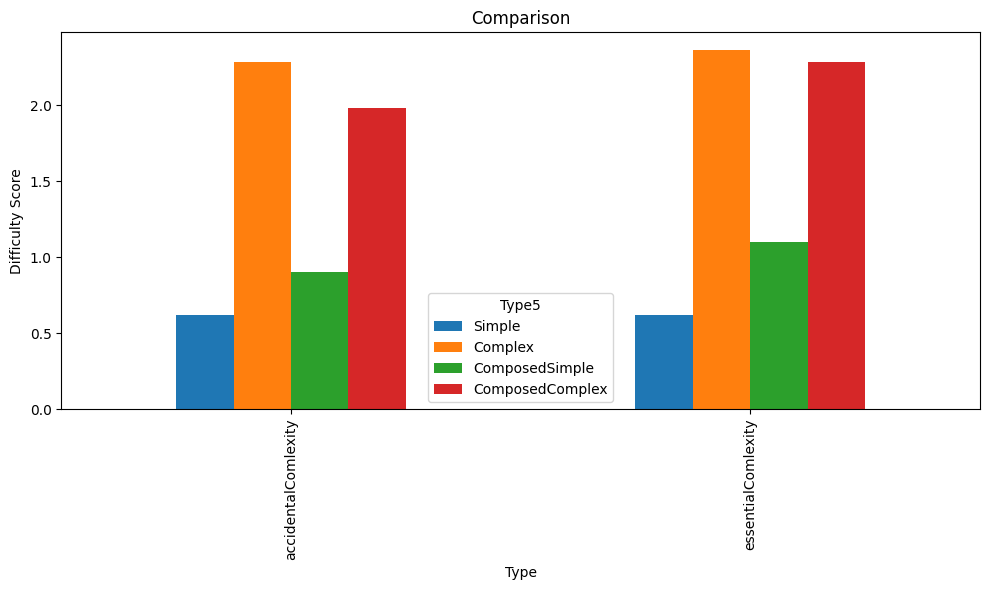

In [10]:
### PERCEIVED DIFFICULTY
measure = 'Difficulty Score'
col = 'difficultyScore'

_df = perceivedDifficultyData

# means = compute_grouped_mean(perceivedDifficultyData, ['Type4','Type3'], ['participant', 'MainQuestionID'], col, additional_filters= {
#     'Type1':'Coarse'
#     })
# means = compute_grouped_mean(_df, ['Type5','Type3'], ['participant', 'MainQuestionID'], col, additional_filters= {})
means, _ = compute_grouped_mean(_df, ['Type5','Type3'], ['participant', 'MainQuestionID'], col, 
                                measure_type='default', measure_type_attr={}, keepExactValues = False,
                                measure_out=None, 
                                additional_filters=None)

# Pivot the table
# pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
pivot_df = means.pivot_table(index='Type3', columns='Type5', values=col)
pivot_df = pivot_df.loc[:,['Simple', 'Complex', 'ComposedSimple', 'ComposedComplex']]
# Display the pivoted data
display(pivot_df)

conditions = [('Simple', 'Complex'), ('ComposedSimple', 'ComposedComplex')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    # res = inf_test(perceivedDifficultyData, ['participant', 'ComparisionGroup','questionID','Type4','Type3'], col, 'Type4', conditions, additional_filters=
    #                             {
    #                              'Type1': 'Fine',
    #                             'Type3': type3})
    _grouped_col = ['participant', 'ComparisionGroup','questionID','Type5','Type3']
    _conditionsMergeOn = _grouped_col[:2]
    _mergeCols = _grouped_col[:3]
    _stat, _p, _n = inferenceTest(_df, 
                                  _grouped_col, col, 'mean', 
                                  'Type5', conditions, _conditionsMergeOn, _mergeCols, 
                                  additional_filters = {'Type3': type3})
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_survey = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)


#### Performance Measures

Type5,Simple,Complex,ComposedSimple,ComposedComplex
Type3,,,,
accidentalComlexity,0.98,0.88,0.92,0.80
essentialComlexity,0.98,0.66,0.94,0.72


essentialComlexity
Simple vs Complex: p-value = 0.00032806396484375
ComposedSimple vs ComposedComplex: p-value = 0.0009765625


accidentalComlexity
Simple vs Complex: p-value = 0.0625
ComposedSimple vs ComposedComplex: p-value = 0.172607421875


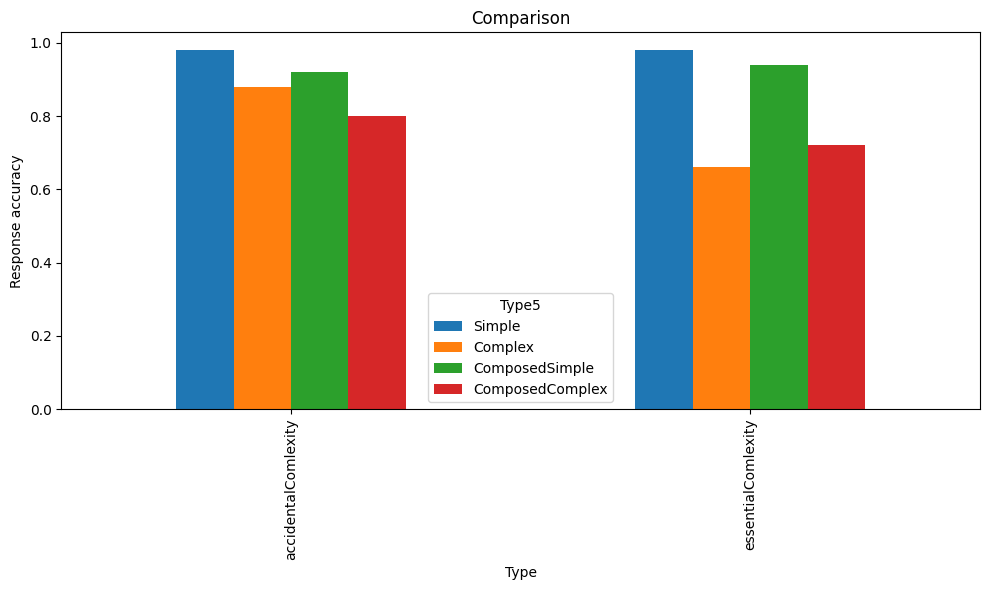

In [11]:
### Answer accuracy
measure = 'Response accuracy'
col = 'accuracy'

_df = answersData

# means = compute_grouped_mean(answersData, ['Type4','Type3'], ['participant', 'questionID'], col, additional_filters= {
#     'Type1':'Coarse',
#     })
# means = compute_grouped_mean(_df, ['Type5','Type3'], ['participant', 'questionID'], col, additional_filters= {})
means, _ = compute_grouped_mean(_df, ['Type5','Type3'], ['participant', 'questionID'], col, 
                                measure_type='default', measure_type_attr={}, keepExactValues = False,
                                measure_out=None, 
                                additional_filters=None)


# Pivot the table
# pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
pivot_df = means.pivot_table(index='Type3', columns='Type5', values=col)
pivot_df = pivot_df.loc[:,['Simple', 'Complex', 'ComposedSimple', 'ComposedComplex']]
# Display the pivoted data
display(pivot_df)

conditions = [('Simple', 'Complex'), ('ComposedSimple', 'ComposedComplex')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    # res = inf_test(answersData, ['participant', 'ComparisionGroup','questionID','Type4','Type3'], col, 'Type4', conditions, additional_filters=
    #                             {
    #                              'Type1': 'Coarse',
    #                             'Type3': type3})
    _grouped_col = ['participant', 'ComparisionGroup','questionID','Type5','Type3']
    _conditionsMergeOn = _grouped_col[:2]
    _mergeCols = _grouped_col[:3]
    _stat, _p, _n = inferenceTest(_df, 
                                  _grouped_col, col, 'mean', 
                                  'Type5', conditions, _conditionsMergeOn, _mergeCols, 
                                  additional_filters = {'Type3': type3})
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))
    

comparison_answers = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#may need more participants

Type5,Simple,Complex,ComposedSimple,ComposedComplex
Type3,,,,
accidentalComlexity,44935.823918,104006.68184,62346.88054,95297.91308
essentialComlexity,44935.823918,145131.19424,89856.76146,143678.87306


essentialComlexity
Simple vs Complex: p-value = 3.552713678800501e-15
ComposedSimple vs ComposedComplex: p-value = 4.2364032282193875e-08


accidentalComlexity
Simple vs Complex: p-value = 3.552713678800501e-15
ComposedSimple vs ComposedComplex: p-value = 1.859966783257505e-06


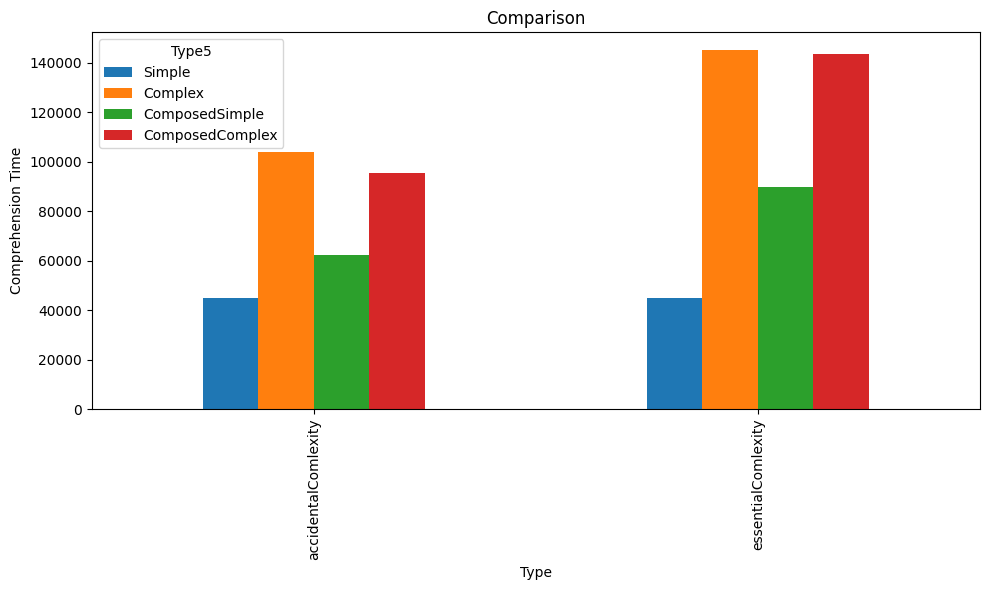

In [12]:
### Comprehension Time
#
# 
measure = 'Comprehension Time'
col = 'ComprehensionTime'

# Keep only MainQuestions
f_eifaData = eifaData[eifaData['Type2'] == 'MainQuestion'].copy(deep=True)
# Group 
# f_eifaData_gr = f_eifaData.groupby(['participant','currentQuestion','Type1','Type2','Type3','Type4','ComparisionGroup'], as_index=False)
f_eifaData_gr = f_eifaData.groupby(['participant','currentQuestion','Type3','Type5','ComparisionGroup'], as_index=False)
# Perform aggregations on grouping:
agg_f_eifaData = f_eifaData_gr.agg(
     newAggCol=('Timestamp', (lambda x: x.iloc[-1]-x.iloc[0])),
)
agg_f_eifaData.rename(columns={'newAggCol': col}, inplace=True)
#flatten
agg_f_eifaData = agg_f_eifaData.reset_index()

_df = agg_f_eifaData

# means = compute_grouped_mean(agg_f_eifaData, ['Type3','Type4'], ['participant', 'currentQuestion'], 
#     measure_col = col,
#     additional_filters = {
#         'Type2':'MainQuestion',
#         'Type1':'Coarse',
#     })
# means = compute_grouped_mean(_df, ['Type3','Type5'], ['participant', 'currentQuestion'], 
#     measure_col = col,
#     additional_filters = {})
means, _ = compute_grouped_mean(_df, ['Type3','Type5'], ['participant', 'currentQuestion'], col, 
                                measure_type='default', measure_type_attr={}, keepExactValues = False,
                                measure_out=None, 
                                additional_filters=None)

# Pivot the table
# pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
pivot_df = means.pivot_table(index='Type3', columns='Type5', values=col)
pivot_df = pivot_df.loc[:,['Simple', 'Complex', 'ComposedSimple', 'ComposedComplex']]
# Display the pivoted data
display(pivot_df)

# to double check
conditions = [('Simple', 'Complex'), ('ComposedSimple', 'ComposedComplex')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    # res = inf_test(agg_f_eifaData, 
    #                ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], 
    #                col, 'Type4', conditions, 
    #                additional_filters= {
    #                    'Type2': 'MainQuestion',
    #                    'Type1': 'Coarse',
    #                    'Type3': type3
    #                 }
    # )
    _grouped_col = ['participant', 'ComparisionGroup','currentQuestion','Type5','Type3']
    _conditionsMergeOn = _grouped_col[:2]
    _mergeCols = _grouped_col[:3]
    _stat, _p, _n = inferenceTest(_df, 
                                  _grouped_col, col, 'mean', 
                                  'Type5', conditions, _conditionsMergeOn, _mergeCols, 
                                  additional_filters = {'Type3': type3})
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_time = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#### Behavioral Measures

Type5,Simple,Complex,ComposedSimple,ComposedComplex
Type3,,,,
accidentalComlexity,88.102041,204.52,122.64,180.08
essentialComlexity,88.122449,232.00,156.98,242.54


essentialComlexity
Simple vs Complex: p-value = 6.750155989720952e-14
ComposedSimple vs ComposedComplex: p-value = 4.521505763577238e-06


accidentalComlexity
Simple vs Complex: p-value = 7.105427357601002e-15
ComposedSimple vs ComposedComplex: p-value = 1.0451820186219152e-05


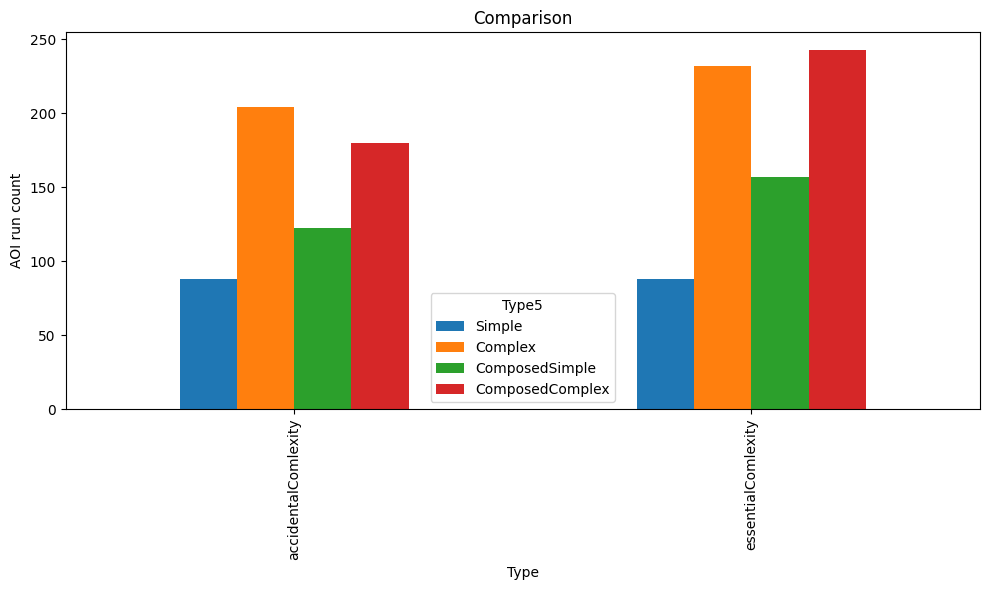

In [ ]:
### Run count -> visual associations/ cognitive integration
measure = 'AOI run count'
col = 'AOIRunCount'

#detect dwells

# Keep only MainQuestions
f_eifaData = eifaData[eifaData['Type2'] == 'MainQuestion'].copy(deep=True)

#Keep only fixations
f_eifaData = f_eifaData.loc[(~f_eifaData['FixID'].isna()) & (~f_eifaData['currentQuestion'].isna())].copy(deep=True)

# Group by consecutive element and aggr by fixation Count -> obtained dwells
f_eifaData["elementCopy"] = f_eifaData["element"]
# f_eifaData_gr = f_eifaData.groupby([(f_eifaData['elementCopy'].shift() != f_eifaData['elementCopy']).cumsum(),'element','tabName','participant','currentQuestion','Type1','Type2','Type3','Type4','ComparisionGroup'], as_index=False).agg(FixationCountPerDwell=('FixID', 'count'))
f_eifaData_gr = f_eifaData.groupby([(f_eifaData['elementCopy'].shift() != f_eifaData['elementCopy']).cumsum(),'element','tabName','participant','currentQuestion','Type1','Type2','Type3','Type4','Type5','ComparisionGroup'], as_index=False).agg(FixationCountPerDwell=('FixID', 'count'))

f_eifaData_gr = f_eifaData_gr.reset_index(drop=True)

#identify transitions
transitions = pd.DataFrame()
# /!\ UPDATE 'identifyTransition' when columns in the dataset change /!\
# transitions[['participant','currentQuestion','Type1','Type3','Type4','tabName','TransitionSource','TransitionTarget','ComparisionGroup']] = f_eifaData_gr.apply(lambda x: identifyTransition(f_eifaData_gr,x.name), axis=1)
transitions[['participant','currentQuestion','Type1','Type3','Type4','Type5','tabName','TransitionSource','TransitionTarget','ComparisionGroup']] = f_eifaData_gr.apply(lambda x: identifyTransition(f_eifaData_gr,x.name), axis=1)
#keep only transitions from AOI to AOI
transitions = transitions[(~transitions['TransitionSource'].isna()) & (~transitions['TransitionTarget'].isna())]
transitions = transitions.reset_index(drop=True)
#add measure attribute
transitions[col] = 1

_df = transitions

# means = compute_grouped_mean_AOIRunCount(transitions, ['Type3','Type4'], ['participant', 'currentQuestion'], col, additional_filters= {
#     'Type1':'Coarse',
#     })
# means = compute_grouped_mean_AOIRunCount(_df, ['Type3','Type5'], ['participant', 'currentQuestion'], col, additional_filters= {})
means, _ = compute_grouped_mean(_df, ['Type3','Type5'], ['participant', 'currentQuestion'], col, 
                                measure_type='AOIRunCount', measure_type_attr={}, keepExactValues = False,
                                measure_out=None, 
                                additional_filters=None)

# Pivot the table
# pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
pivot_df = means.pivot_table(index='Type3', columns='Type5', values=col)
pivot_df = pivot_df.loc[:,['Simple', 'Complex', 'ComposedSimple', 'ComposedComplex']]
# Display the pivoted data
display(pivot_df)

conditions = [('Simple', 'Complex'), ('ComposedSimple', 'ComposedComplex')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    # res = inf_test_AOIRunCount(transitions, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
    #                             {
    #                              'Type1': 'Coarse',
    #                             'Type3': type3})
    _grouped_col = ['participant', 'ComparisionGroup','currentQuestion','Type5','Type3']
    _conditionsMergeOn = _grouped_col[:2]
    _mergeCols = _grouped_col[:3]
    _stat, _p, _n = inferenceTest(_df, 
                                  _grouped_col, col, 'count', 
                                  'Type5', conditions, _conditionsMergeOn, _mergeCols, 
                                  additional_filters = {'Type3': type3})
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))
    

comparison_runcount = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

Type5,Simple,Complex,ComposedSimple,ComposedComplex
Type3,,,,
accidentalComlexity,27.857143,71.18,36.7,62.30
essentialComlexity,27.857143,85.48,53.8,83.56


essentialComlexity
Simple vs Complex: p-value = 7.105427357601002e-15
ComposedSimple vs ComposedComplex: p-value = 1.6015611617348213e-05


accidentalComlexity
Simple vs Complex: p-value = 3.552713678800501e-15
ComposedSimple vs ComposedComplex: p-value = 3.38235121510877e-06


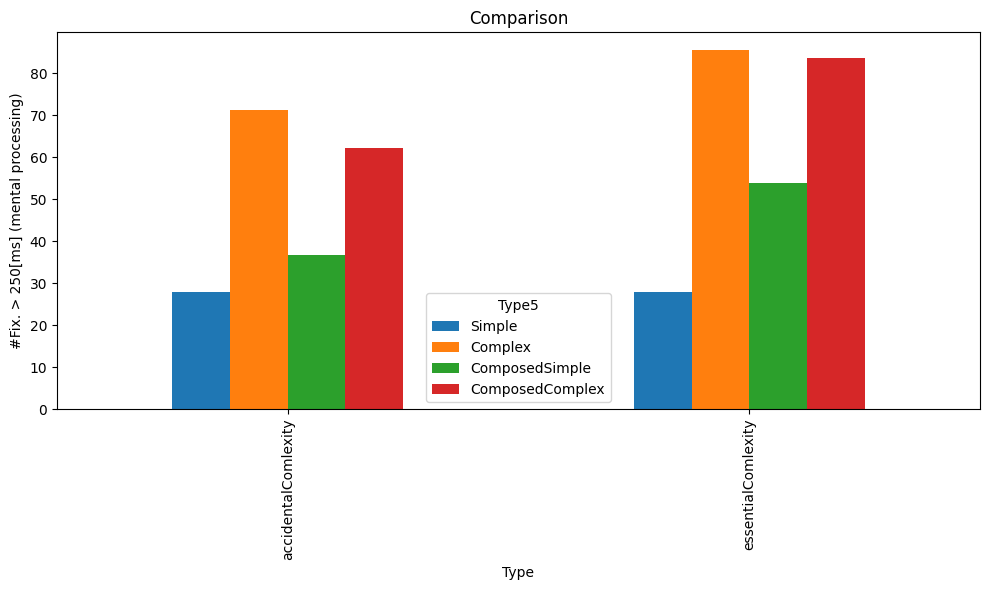

In [14]:
### AVERAGE COUNT OF FIXATIONS ABOVE 250MS (MENTAL PROCESSING)
measure = '#Fix. > 250[ms] (mental processing)'
col = 'Fixation Duration'

#select fixation data and drop na
fixationData = eifaData.loc[(~eifaData['FixID'].isna()) & (~eifaData['currentQuestion'].isna())].copy(deep=True)
#set fixation threshold
fixationData = fixationData[fixationData['Fixation Duration']>250]

_df = fixationData

# means = compute_grouped_mean_fixationCount(fixationData, ['Type4','Type3'], ['participant', 'currentQuestion'], measure_col=col, additional_filters= {
#     'Type2':'MainQuestion',
#     'Type1':'Coarse',
#     })
# means = compute_grouped_mean_fixationCount(fixationData, ['Type5','Type3'], ['participant', 'currentQuestion'], measure_col=col, additional_filters= {
#     'Type2':'MainQuestion'
#     })
means, _ = compute_grouped_mean(fixationData, ['Type5','Type3'], ['participant', 'currentQuestion'], col, 
                                measure_type='FixationCount', measure_type_attr={}, keepExactValues = False,
                                measure_out=None, 
                                additional_filters={'Type2':'MainQuestion'})



# Pivot the table
# pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
pivot_df = means.pivot_table(index='Type3', columns='Type5', values=col)
pivot_df = pivot_df.loc[:,['Simple', 'Complex', 'ComposedSimple', 'ComposedComplex']]
# Display the pivoted data
display(pivot_df)

conditions = [('Simple', 'Complex'), ('ComposedSimple', 'ComposedComplex')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    # res = inf_test_fixationCount(fixationData, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
    #                             {'Type2': 'MainQuestion',
    #                              'Type1': 'Coarse',
    #                              'Type3': type3})
    _grouped_col = ['participant', 'ComparisionGroup','currentQuestion','Type5','Type3']
    _conditionsMergeOn = _grouped_col[:2]
    _mergeCols = _grouped_col[:3]
    _stat, _p, _n = inferenceTest(_df,  
                                  _grouped_col, col, 'count', 
                                  'Type5', conditions, _conditionsMergeOn, _mergeCols, 
                                  additional_filters = {'Type2': 'MainQuestion', 'Type3': type3})
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))
    

comparison_cntfix250 = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

Type5,Simple,Complex,ComposedSimple,ComposedComplex
Type3,,,,
accidentalComlexity,4.25,11.877551,5.080000,10.734694
essentialComlexity,4.25,12.320000,7.326531,12.300000


essentialComlexity
Simple vs Complex: p-value = 6.076561476220377e-11
ComposedSimple vs ComposedComplex: p-value = 8.290405602906503e-06


accidentalComlexity
Simple vs Complex: p-value = 1.4149748039926635e-10
ComposedSimple vs ComposedComplex: p-value = 2.2854558210383402e-06


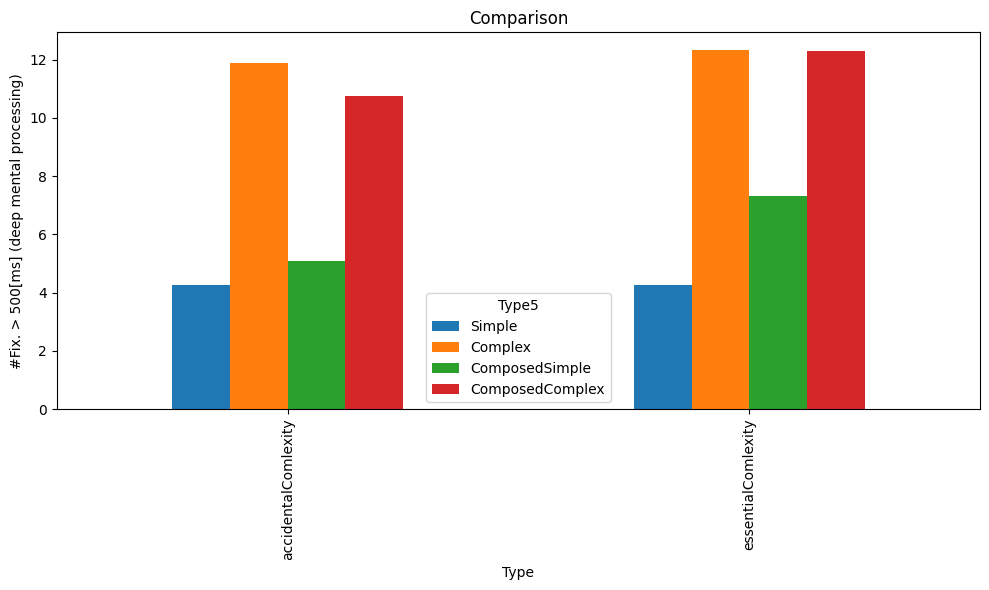

In [15]:
### AVERAGE COUNT OF FIXATIONS ABOVE 500MS (DEEP MENTAL PROCESSING)
measure = '#Fix. > 500[ms] (deep mental processing)'
col = 'Fixation Duration'

#select fixation data and drop na
fixationData = eifaData.loc[(~eifaData['FixID'].isna()) & (~eifaData['currentQuestion'].isna())].copy(deep=True)
#set fixation threshold
fixationData = fixationData[fixationData['Fixation Duration']>500]

_df = fixationData

# means =compute_grouped_mean_fixationCount(fixationData, ['Type4','Type3'], ['participant', 'currentQuestion'], measure_col=col, additional_filters= {
#     'Type2':'MainQuestion',
#     'Type1':'Coarse',
#     })
# means =compute_grouped_mean_fixationCount(fixationData, ['Type5','Type3'], ['participant', 'currentQuestion'], measure_col=col, additional_filters= {
#     'Type2':'MainQuestion'
#     })
means, _ = compute_grouped_mean(fixationData, ['Type5','Type3'], ['participant', 'currentQuestion'], col, 
                                measure_type='FixationCount', measure_type_attr={}, keepExactValues = False,
                                measure_out=None, 
                                additional_filters={'Type2':'MainQuestion'})

# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type5', values=col)
pivot_df = pivot_df.loc[:,['Simple', 'Complex', 'ComposedSimple', 'ComposedComplex']]
# Display the pivoted data
display(pivot_df)

conditions = [('Simple', 'Complex'), ('ComposedSimple', 'ComposedComplex')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    # res = inf_test_fixationCount(fixationData, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
    #                             {'Type2': 'MainQuestion',
    #                              'Type1': 'Coarse',
    #                              'Type3': type3})
    _grouped_col = ['participant', 'ComparisionGroup','currentQuestion','Type5','Type3']
    _conditionsMergeOn = _grouped_col[:2]
    _mergeCols = _grouped_col[:3]
    _stat, _p, _n = inferenceTest(_df, 
                                  _grouped_col, col, 'count', 
                                  'Type5', conditions, _conditionsMergeOn, _mergeCols, 
                                  additional_filters = {'Type2': 'MainQuestion', 'Type3': type3})
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_cntfix500 = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#### Physiological Measures

c:\DEV\NASSY\nassy-eyemind_plus-beta\utils\lhipa_utils.py:67: UserWarning: Input signal size (=91) lower than the minimum (=100). Returned NaN.
  warn(f'Input signal size (={len(d)}) lower than the minimum (={min_sample_size}). Returned NaN.')
c:\DEV\NASSY\nassy-eyemind_plus-beta\utils\lhipa_utils.py:67: UserWarning: Input signal size (=89) lower than the minimum (=100). Returned NaN.
  warn(f'Input signal size (={len(d)}) lower than the minimum (={min_sample_size}). Returned NaN.')


Type5,Simple,Complex,ComposedSimple,ComposedComplex
Type3,,,,
accidentalComlexity,1.323305,0.785463,1.143216,0.848789
essentialComlexity,1.323305,0.636713,0.920795,0.678784


essentialComlexity
Simple vs Complex: p-value = 9.947598300641403e-14
ComposedSimple vs ComposedComplex: p-value = 0.0006983914307809869


accidentalComlexity
Simple vs Complex: p-value = 2.3521806724602357e-09
ComposedSimple vs ComposedComplex: p-value = 9.55255321741788e-05


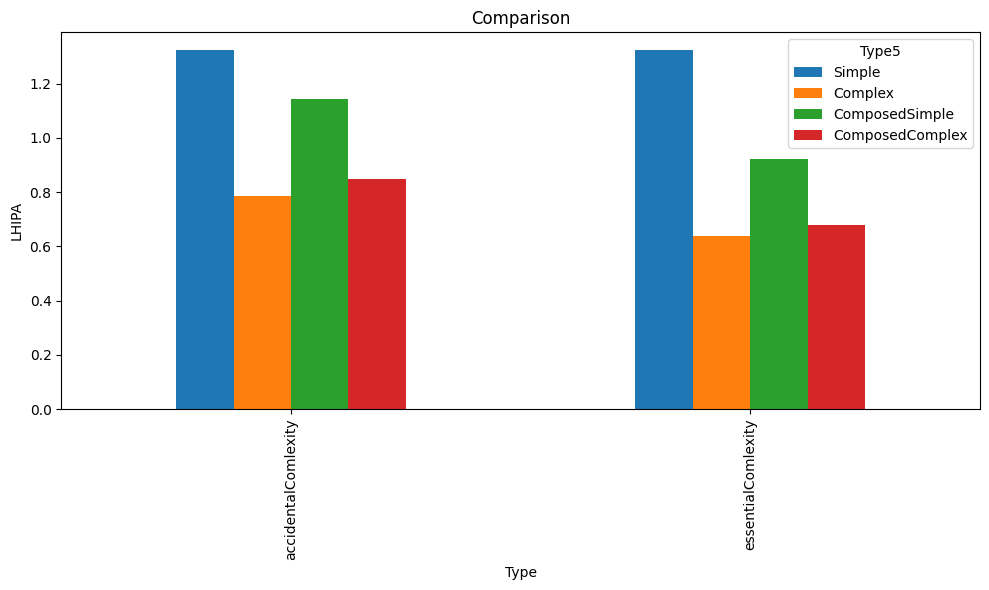

In [16]:
### LHIPA
measure = 'LHIPA'
col = 'LHIPA'

pupiFiltered_l = pupiFiltered[(pupiFiltered['Type2'] == 'MainQuestion') & (~pupiFiltered['tabName'].isna())].copy(deep=True)
# pupiFiltered_l = pupiFiltered_l.groupby(['participant', 'currentQuestion', 'Type1', 'Type2','Type3','Type4','ComparisionGroup'])
pupiFiltered_l = pupiFiltered_l.groupby(['participant', 'currentQuestion', 'Type2','Type3','Type5','ComparisionGroup'])

## Compute LHIPA for each group - LHIPA is expected to decrease with increased cognitive load
# Compute LHIPA with default 'sym5' wavelet
_lhipa = lambda df: lhipa(df['pupilSize'], df['Timestamp'])
pupiFiltered_l = pupiFiltered_l.apply(_lhipa).reset_index()
pupiFiltered_l = pupiFiltered_l.rename(columns={0: col})

_df = pupiFiltered_l

# means = compute_grouped_mean(pupiFiltered_l, 
#                              ['Type3','Type4'], 
#                              ['participant', 'currentQuestion'], 
#                              col, additional_filters= {'Type2':'MainQuestion', 'Type1':'Coarse', })
# means = compute_grouped_mean(_df, ['Type3','Type5'], ['participant', 'currentQuestion'], col, 
#                              additional_filters= {'Type2':'MainQuestion' })
means, _ = compute_grouped_mean(_df, ['Type3','Type5'], ['participant', 'currentQuestion'], col, 
                                measure_type='default', measure_type_attr={}, keepExactValues = False,
                                measure_out=None, 
                                additional_filters={'Type2':'MainQuestion' })


# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type5', values=col)
pivot_df = pivot_df.loc[:,['Simple', 'Complex', 'ComposedSimple', 'ComposedComplex']]
# Display the pivoted data
display(pivot_df)

# to double check
conditions = [('Simple', 'Complex'), ('ComposedSimple', 'ComposedComplex')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    # res = inf_test(pupiFiltered_l, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
    #                             {
    #                              'Type2': 'MainQuestion',
    #                              'Type1': 'Coarse',
    #                             'Type3': type3})
    _grouped_col = ['participant', 'ComparisionGroup','currentQuestion','Type5','Type3']
    _conditionsMergeOn = _grouped_col[:2]
    _mergeCols = _grouped_col[:3]
    _stat, _p, _n = inferenceTest(_df, 
                                  _grouped_col, col, 'mean', 
                                  'Type5', conditions, _conditionsMergeOn, _mergeCols, 
                                  additional_filters = {'Type2': 'MainQuestion', 'Type3': type3})
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))
    

comparison_lhipa = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

## Summary
Bars of representative metrics (one for each categories). The expected tendencies for simple and complex tasks are indicated in the legends as an arrow (pointing down for expected low value and conversely).

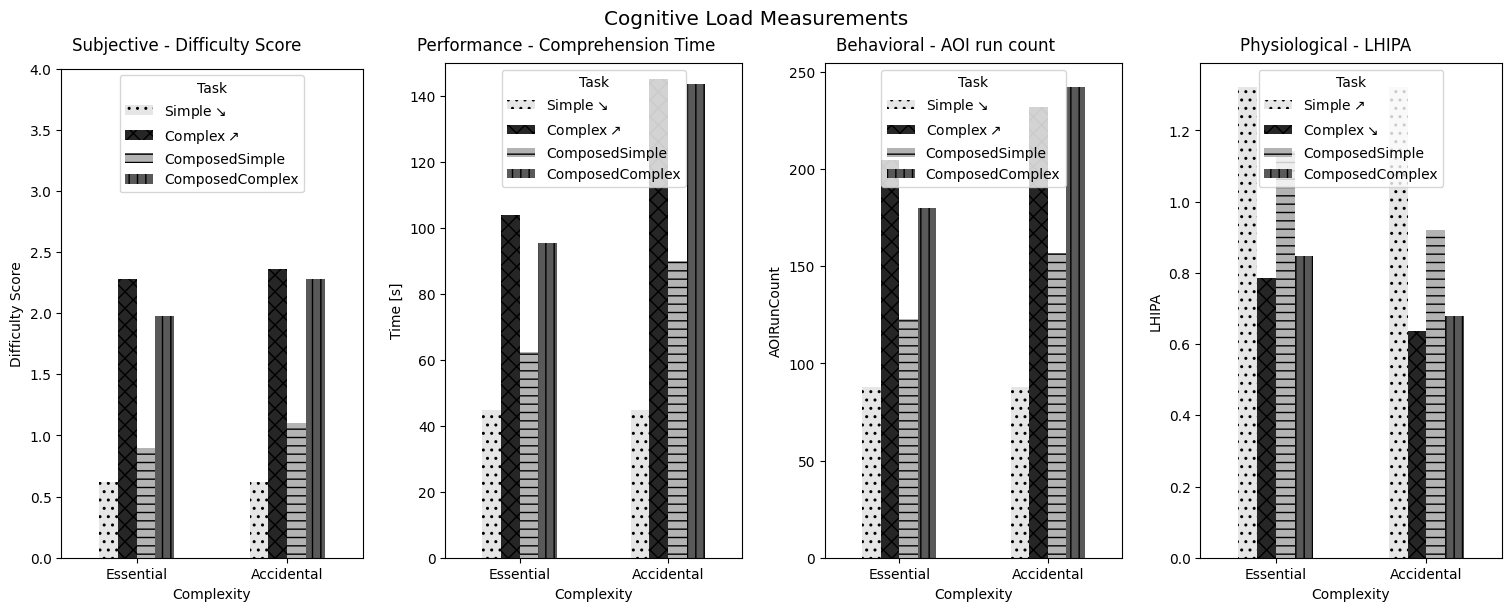

In [17]:
class MyBars4:
    kind = 'bar'
    hatches = ['..', '..', 'xx', 'xx',
               '--', '--', '||', '||']
    colors = []
    grays = ['.90', '.90', '.15', '.15',
             '.70', '.70', '.35', '.35']

    def __init__(self, fig = None, ax = None):
        if fig is None or ax is None:
            self.fig = plt.figure(layout='constrained', figsize=(15, 6))
            self.ax = [None, None, None, None]
        else:
            self.fig, self.ax = fig, ax
        
        self.sf = self.fig.subfigures(1, 4, wspace=0.05)
        self.ax = [sf.subplots() for sf in self.sf]
        self.pivots = [None, None, None, None]
        self.measures = [None, None, None, None]

    # DEF: __init__

    def set_bar(self, pos, pivot, measure):
        if pos in range(4):
            self.pivots[pos] = pivot
            self.measures[pos] = measure

            self.pivots[pos].plot(kind=MyBars4.kind, ax=self.ax[pos])
            self.ax[pos].set_ylabel(self.measures[pos])

            for _ax, h, c in zip(self.ax[pos].patches, MyBars4.hatches, MyBars4.grays):
                _ax.set_hatch(h)
                _ax.set_facecolor(c)
        else:
            raise IndexError('Position out of range (0:3).')
    # DEF: set_bar

    def set_title(self, pos, title):
        if not(pos in range(-1,4)): raise IndexError('Position out of range (-1:3).')

        if pos == -1: self.fig.suptitle(title, fontsize='x-large')
        else: self.sf[pos].suptitle(title)
    # DEF: set_title

    def set_label(self, pos, axis, label):
        if not(pos in range(4)): raise IndexError('Position out of range (0:3).')
        
        if (axis == 0) or (axis == 'x'):
            self.ax[pos].set_xlabel(label)
        elif (axis == 1) or (axis == 'y'):
            self.ax[pos].set_ylabel(label)
        else: raise IndexError(f'Unknown axis ({axis}).')
    # DEF: set_ylabel
    def set_ylabel(self, pos, label): self.set_label(pos, 1, label)
    def set_xlabel(self, pos, label): self.set_label(pos, 0, label)

# CLASS: MyBars4


myBars = MyBars4()
myBars.set_title(-1, 'Cognitive Load Measurements')

myBars.set_bar(0, comparison_survey['pivot'], comparison_survey['measure'])
myBars.set_xlabel(0, 'Complexity')
myBars.ax[0].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_ylabel(0, 'Difficulty Score')
myBars.set_title(0, 'Subjective - ' + comparison_survey['label'])
myBars.ax[0].set_ylim([0, 4])
myBars.ax[0].legend(title='Task', loc='upper center')
lg = myBars.ax[0].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\searrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\nearrow$')

myBars.set_bar(1, comparison_time['pivot']/1000, comparison_time['measure'])
myBars.set_xlabel(1, 'Complexity')
myBars.ax[1].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_ylabel(1, 'Time [s]')
myBars.set_title(1, 'Performance - ' + comparison_time['label'])
myBars.ax[1].set_ylim([0, 150])
myBars.ax[1].legend(title='Task', loc='upper center')
lg = myBars.ax[1].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\searrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\nearrow$')

myBars.set_bar(2, comparison_runcount['pivot'], comparison_runcount['measure'])
myBars.set_xlabel(2, 'Complexity')
myBars.ax[2].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_title(2, 'Behavioral - ' + comparison_runcount['label'])
myBars.ax[2].legend(title='Task', loc='upper center')
lg = myBars.ax[2].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\searrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\nearrow$')

# myBars.set_bar(3, comparison_cntfix250['pivot'], comparison_cntfix250['measure'])
# myBars.set_bar(3, comparison_cntfix500['pivot'], comparison_cntfix500['measure'])
myBars.set_bar(3, comparison_lhipa['pivot'], comparison_lhipa['measure'])
myBars.set_xlabel(3, 'Complexity')
myBars.ax[3].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_title(3, 'Physiological - ' + comparison_lhipa['label'])
myBars.ax[3].legend(title='Task', loc='upper center')
lg = myBars.ax[3].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\nearrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\searrow$')


_dir = IMG_DIR + r"\Coarse-grained analysis 2"
if not os.path.isdir(_dir):
    os.mkdir(_dir)
plt.savefig(_dir + r"\Coarse-grained_analysis_comparaisons_measures.pdf")
plt.savefig(_dir + r"\Coarse-grained_analysis_comparaisons_measures.png")


plt.show()